In [ ]:
!unzip stanford_dogs_dataset.zip

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np  
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm import tqdm
from PIL import Image

In [8]:

PATH_train="stanford_dogs_dataset/train"
PATH_test="stanford_dogs_dataset/test"
TRAIN =Path(PATH_train)
TEST =Path(PATH_test)
batch_size = 32
LR = 0.0001

train_transforms = transforms.Compose([
                                transforms.RandomCrop((400,400), pad_if_needed = True, ),
                                transforms.RandomHorizontalFlip(p=0.9),
                                #transforms.ColorJitter(brightness=(0, 5), contrast=(0, 5), saturation=(0, 5), hue=(-0.1, 0.1)),
                                transforms.RandomRotation(30, expand=False, center=(200, 200)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
                                ])

test_transforms = transforms.Compose([
                                transforms.RandomCrop((400,400), pad_if_needed = True),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
                                ])


train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)
print(train_data.class_to_idx)
print(test_data.class_to_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

{'Afghan_hound': 0, 'Airedale': 1, 'Bernese_mountain_dog': 2, 'Irish_wolfhound': 3, 'Leonberg': 4, 'Scottish_deerhound': 5, 'Tibetan_terrier': 6, 'basenji': 7}
{'Afghan_hound': 0, 'Airedale': 1, 'Bernese_mountain_dog': 2, 'Irish_wolfhound': 3, 'Leonberg': 4, 'Scottish_deerhound': 5, 'Tibetan_terrier': 6, 'basenji': 7}


### **Implement VGG16 model**

In [9]:
# N = (W-k+2P)/S + 1
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # input_shape=(3,224,224)
        self.cnn3_64 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) 
        self.cnn64_64 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) 
        self.relu1 = nn.ReLU(inplace=True) 
        #(224-3)/1 + 1 = 222
        # Max pool 1 (8, 222, 222)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cnn64_128 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) 
        self.cnn128_128 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 

        self.cnn128_256 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) 
        self.cnn256_256 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 

        self.cnn256_512 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1) 
        self.cnn512_512 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1) 

        
        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 8)
        self.bn1 = nn.BatchNorm2d(512)
        self.sm = nn.Softmax(dim=1)
    def forward(self, x):
        out = self.relu1(self.cnn3_64(x))
        out = self.relu1(self.cnn64_64(out))
        out = self.maxpool(out)


        out = self.relu1(self.cnn64_128(out))
        out = self.relu1(self.cnn128_128(out))
        out = self.maxpool(out)

        out = self.relu1(self.cnn128_256(out))
        out = self.relu1(self.cnn256_256(out))
        out = self.relu1(self.cnn256_256(out))
        out = self.maxpool(out)

        out = self.relu1(self.cnn256_512(out))
        out = self.relu1(self.cnn512_512(out))
        out = self.relu1(self.cnn512_512(out))
        out = self.maxpool(out)

        out = self.relu1(self.cnn512_512(out))
        out = self.relu1(self.cnn512_512(out))
        out = self.relu1(self.cnn512_512(out))
        out = self.maxpool(out)

        out = self.bn1(out)
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.sm(self.fc3(out))

        return out

### **Implement simple CNN model**

In [14]:
class LittleCNN(nn.Module):
  
    def __init__(self):
        super(LittleCNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.fc6 = nn.Linear(50*50*8, 64) # *******
        #self.bn_fc = nn.BatchNorm1d(32)
        self.fc8 = nn.Linear(64, 8)       # *******
        
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        #conv block 1
        x = self.conv1_1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        
        x = x.reshape(-1, 50*50*8)
        
        #fc6
        x = self.fc6(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = self.fc8(x)
        x = F.softmax(x, dim=1)
        
        return x

In [15]:
def train(model,n_epochs,train_loader,valid_loader, LR = 0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    #optimizer = torch.optim.Adam(model.parameters(),lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0)
    #optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.5, dampening=0, weight_decay=0, nesterov=False)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, alpha=0.99, eps=1e-08, weight_decay=0.1, momentum=0, centered=False)
    criterion = CrossEntropyLoss()
    train_acc_his,valid_acc_his=[],[]
    train_losses_his,valid_losses_his=[],[]
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss,valid_loss = 0.0,0.0
        train_losses,valid_losses=[],[]
        train_correct,val_correct,train_total,val_total=0,0,0,0
        train_pred,train_target=torch.zeros(batch_size,1),torch.zeros(batch_size,1)
        val_pred,val_target=torch.zeros(batch_size,1),torch.zeros(batch_size,1)
        count=0
        count2=0
        print('running epoch: {}'.format(epoch))
        model = model.cuda()
        model.train()
        for data, target in tqdm(train_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            #print('output.shape', output.shape)
            loss = criterion(output, target)
            pred = output.data.max(dim = 1, keepdim = True)[1]
            #print('pred.shape', pred.shape)
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item()*data.size(0))
            optimizer.zero_grad()
            if count==0:
                train_pred=pred
                train_target=target.data.view_as(pred)
                count=count+1
            else:
                train_pred=torch.cat((train_pred,pred), 0)
                train_target=torch.cat((train_target,target.data.view_as(pred)), 0)
        train_pred=train_pred.cpu().view(-1).numpy().tolist()
        train_target=train_target.cpu().view(-1).numpy().tolist()
        model.eval()
        for data, target in tqdm(valid_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss =criterion(output, target)
            pred = output.data.max(dim = 1, keepdim = True)[1]
            val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            val_total += data.size(0)
            valid_losses.append(loss.item()*data.size(0))
            if count2==0:
                val_pred=pred
                val_target=target.data.view_as(pred)
                count2=count+1
            else:
                val_pred=torch.cat((val_pred,pred), 0)
                val_target=torch.cat((val_target,target.data.view_as(pred)), 0)
        val_pred=val_pred.cpu().view(-1).numpy().tolist()
        val_target=val_target.cpu().view(-1).numpy().tolist()
        
        # calculate average losses
        train_loss=np.average(train_losses)
        valid_loss=np.average(valid_losses)
        
        # calculate average accuracy
        train_acc=train_correct/train_total
        valid_acc=val_correct/val_total
        train_acc_his.append(train_acc)
        valid_acc_his.append(valid_acc)
        train_losses_his.append(train_loss)
        valid_losses_his.append(valid_loss)
# print training/validation statistics 
        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            train_loss, valid_loss))
        print('\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            train_acc, valid_acc))
    return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

### Using simple CNN model with **softmax**  
### => *overfitting*

In [ ]:
model1=LittleCNN()
n_epochs = 100

train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader)

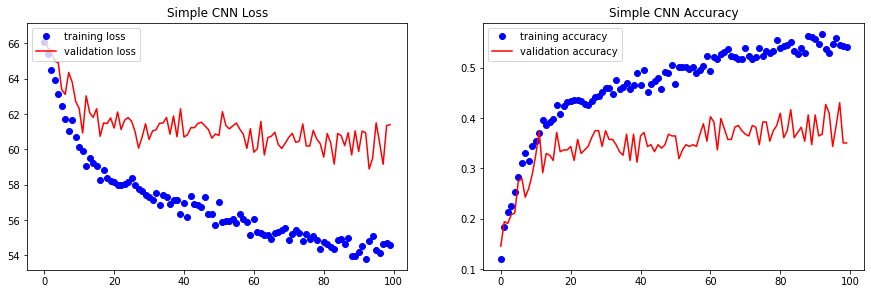

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.show()

### Using data not very complex and simple CNN model with **no softmax & 3 FC Layers** & batch size 32 
### *=> Little overfitting but not serious*

In [ ]:
class LittleCNN(nn.Module):
  
    def __init__(self):
        super(LittleCNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.fc6 = nn.Linear(50*50*8, 32) # *******
        #self.bn_fc = nn.BatchNorm1d(32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 8)       # *******
        
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        #conv block 1
        x = self.conv1_1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        
        x = x.reshape(-1, 50*50*8)
        
        #fc6
        x = self.fc6(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = self.fc7(x)
        x = F.relu(x)
        x = self.fc8(x)
        #x = F.softmax(x, dim=1)
        
        return x

In [ ]:
model1=LittleCNN()
n_epochs = 100

train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader)

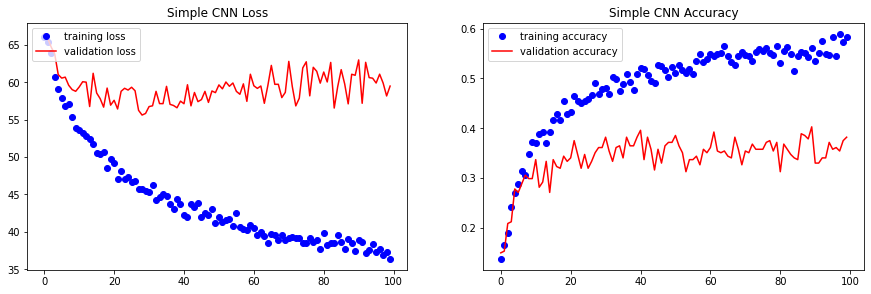

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.show()

### **Add dropout and finetune this model**
=> not work really well

In [ ]:
#dropout 0.1, continue training 
model1=LittleCNN()
model1 = torch.load("cnn_drop0.2.65-0.45.pth")
train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader)

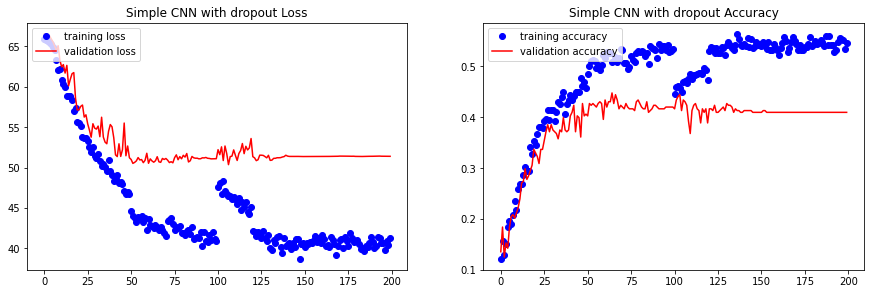

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN with dropout Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN with dropout Accuracy")
plt.legend(loc='upper left')
plt.show()

### Modify this simple CNN model with **1 fully connected layers**
### => overfitting

In [ ]:
class LittleCNN(nn.Module):
  
    def __init__(self):
        super(LittleCNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.fc6 = nn.Linear(50*50*8, 8) 
        
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        #conv block 1
        x = self.conv1_1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        
        x = x.reshape(-1, 50*50*8)
        
        x = self.fc6(x)
        
        return x

In [ ]:
model1=LittleCNN()
n_epochs = 100

train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader)

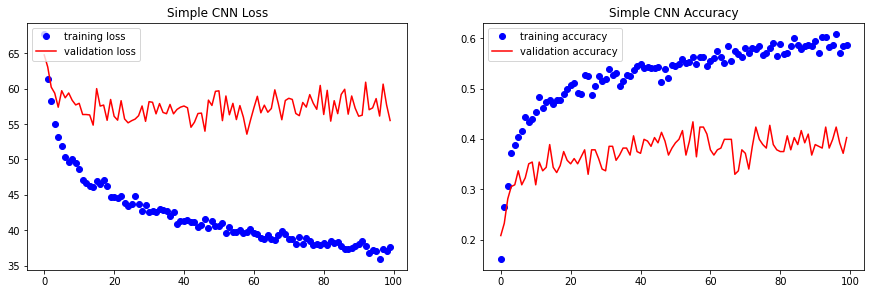

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.show()
#torch.save(model1, "CNN.pt")
#model1 = torch.load('CNN.pt')

### Modify this simple CNN model with **2 fully connected layers**
### *=> Fix most overfitting part*

In [ ]:
class LittleCNN(nn.Module):
  
    def __init__(self):
        super(LittleCNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.fc6 = nn.Linear(40*40*8, 32)
        self.bn_fc = nn.BatchNorm1d(32)
        self.fc7 = nn.Linear(32, 8)
        
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        #conv block 1
        x = self.conv1_1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        
        x = x.reshape(-1, 40*40*8)
        
        #fc6
        x = self.fc6(x)
        x = F.relu(x)
        #x = self.dropout(x)
        
        x = self.fc7(x)
        #x = F.softmax(x, dim=1)
        
        return x

In [ ]:
model1=LittleCNN()
n_epochs = 100

train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader)

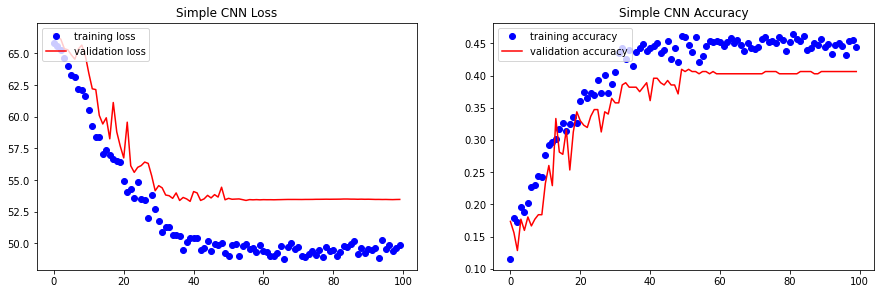

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.show()
#torch.save(model1, "CNN.pt")
#model1 = torch.load('CNN.pt')

# **2(a) ResNet with residual blocks**

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
import os


In [2]:
def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

In [3]:
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)    

In [4]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, should_apply_shortcut= True, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation, self.should_apply_shortcut = in_channels, out_channels, activation, should_apply_shortcut
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    

In [5]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, should_apply_shortcut= True, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):#=conv3x3
        super().__init__(in_channels, out_channels, should_apply_shortcut, *args, **kwargs)
        self.expansion, self.downsampling, self.conv, self.should_apply_shortcut = expansion, downsampling, conv, should_apply_shortcut
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    

In [6]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))

In [7]:
class ResNetBasicBlock(ResNetResidualBlock):
    
    expansion = 1
    def __init__(self, in_channels, out_channels, should_apply_shortcut= True, *args, **kwargs):
        super().__init__(in_channels, out_channels, should_apply_shortcut, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [9]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, should_apply_shortcut= True, block=ResNetBasicBlock, n=1, *args, **kwargs):#代表有n 個 blocks
        super().__init__()
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, should_apply_shortcut=should_apply_shortcut, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, should_apply_shortcut=should_apply_shortcut, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [10]:
class ResNetEncoder(nn.Module):
    def __init__(self, in_channels=3, should_apply_shortcut= True, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], should_apply_shortcut=should_apply_shortcut, n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, should_apply_shortcut=should_apply_shortcut, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [11]:
class ResnetDecoder(nn.Module):
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [12]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, should_apply_shortcut= True, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, should_apply_shortcut, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

In [14]:
def resnet18_no_identity(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, should_apply_shortcut= False, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

In [15]:

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, data_loader, optimizer, epoch,scheduler, verbose=True):
    model.train()
    loss_avg = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        
        # loss function
        criterion  = nn.CrossEntropyLoss()
        loss   = criterion (output, target)
        loss_avg += loss.item()
        
        # do back propagation
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        
        #print
        #verbose_step = len(data_loader) // 10
        verbose_step=100
        if batch_idx % verbose_step == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
    return loss_avg / len(data_loader)

def valid(model, data_loader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        correct = 0
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #00
            criterion  = nn.CrossEntropyLoss()
            loss   = criterion (output, target)
            loss_avg = loss.item()
            valid_loss +=loss_avg  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item() 

        #valid_loss /= len(data_loader.dataset)
        valid_loss /= len(data_loader)
        print('Valid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            valid_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
    return float(correct) / len(data_loader.dataset)

In [16]:
model=resnet18(3,8)
model.to(device=device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:

#
lr=3e-4
#optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.09, dampening=0)
optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=10, min_lr=0.000001, eps=1e-08, threshold=0.0001, threshold_mode='rel', cooldown=0, verbose=True)
# start training
epochs = 600
acc = 0.4
for epoch in range(epochs):
    #model.train()
    loss = train(model, train_loader, optimizer, epoch,scheduler)
    print('-> Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss))
    accuracy = valid(model, valid_loader)
    scheduler.step(loss)
    if accuracy > acc:
        acc = accuracy
        print("-------------saving model--------------")
        # save the model
        torch.save(model, "resnet.{:02d}-{:.2f}.pth".format(epoch,accuracy))

# **2(b) Remove the identity mapping**

In [ ]:
model=resnet18_no_identity(3,8)
model.to(device=device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:

#
lr=3e-4
#optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.09, dampening=0)
optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=10, min_lr=0.000001, eps=1e-08, threshold=0.0001, threshold_mode='rel', cooldown=0, verbose=True)
# start training
epochs = 600
acc = 0.4
for epoch in range(epochs):
    #model.train()
    loss = train(model, train_loader, optimizer, epoch,scheduler)
    print('-> Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss))
    accuracy = valid(model, valid_loader)
    scheduler.step(loss)
    if accuracy > acc:
        acc = accuracy
        print("-------------saving model--------------")
        # save the model
        torch.save(model, "resnet.{:02d}-{:.2f}.pth".format(epoch,accuracy))